1. Load the dataset

In [ ]:
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score
)

import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the data
df = pd.read_csv('/content/drive/MyDrive/ML_LAB/LoanPrediction_LR/train.csv')
df

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,...,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,...,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,...,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,...,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,...,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,C-43723,Angelyn Clevenger,M,38,4969.41,Low,Commercial associate,Managers,Urban,76657.90,...,869.61,0,Unpossessed,566,4969.41,4,Urban,1,111096.56,68992.11
29996,C-32511,Silas Slaugh,M,20,1606.88,Low,Working,Laborers,Semi-Urban,66595.14,...,729.41,0,Inactive,175,1606.88,3,Urban,1,73453.94,46616.60
29997,C-5192,Carmelo Lone,F,49,NaN,Low,Working,Sales staff,Urban,81410.08,...,NaN,0,Active,959,NaN,1,Rural,1,102108.02,61057.56
29998,C-12172,Carolann Osby,M,38,2417.71,Low,Working,Security staff,Semi-Urban,142524.10,...,677.27,1,Unpossessed,375,2417.71,4,Urban,1,168194.47,99766.87


 2.Perform EDA (class balance, feature distributions).

a. Handling Missing Values

In [ ]:
df.isnull().sum()[df.isnull().sum() > 0]

,0
Gender,53
Income (USD),4576
Income Stability,1683
Type of Employment,7270
Current Loan Expenses (USD),172
Dependents,2493
Credit Score,1703
Has Active Credit Card,1566
Property Age,4850
Property Location,356


In [ ]:
# Fill categorical columns with mode or default string
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Income Stability'] = df['Income Stability'].fillna(df['Income Stability'].mode()[0])
df['Type of Employment'] = df['Type of Employment'].fillna('Unknown')
df['Has Active Credit Card'] = df['Has Active Credit Card'].fillna('Unknown')
df['Property Location'] = df['Property Location'].fillna(df['Property Location'].mode()[0])

# Fill numerical columns with mean/median
df['Income (USD)'] = df['Income (USD)'].fillna(df['Income (USD)'].mean())
df['Current Loan Expenses (USD)'] = df['Current Loan Expenses (USD)'].fillna(df['Current Loan Expenses (USD)'].mean())
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].median())
df['Dependents'] = df['Dependents'].astype(int)
df['Credit Score'] = df['Credit Score'].fillna(df['Credit Score'].mean())
df['Property Age'] = df['Property Age'].fillna(df['Property Age'].mean())

# Drop rows where target is missing
df = df.dropna(subset=['Loan Sanction Amount (USD)'])


In [ ]:
df.isnull().sum()

,0
Customer ID,0
Name,0
Gender,0
Age,0
Income (USD),0
Income Stability,0
Profession,0
Type of Employment,0
Location,0
Loan Amount Request (USD),0


In [ ]:
print("Data shape after handling null values:", df.shape)

Data shape after handling null values: (29660, 24)


b. Handling Outliers

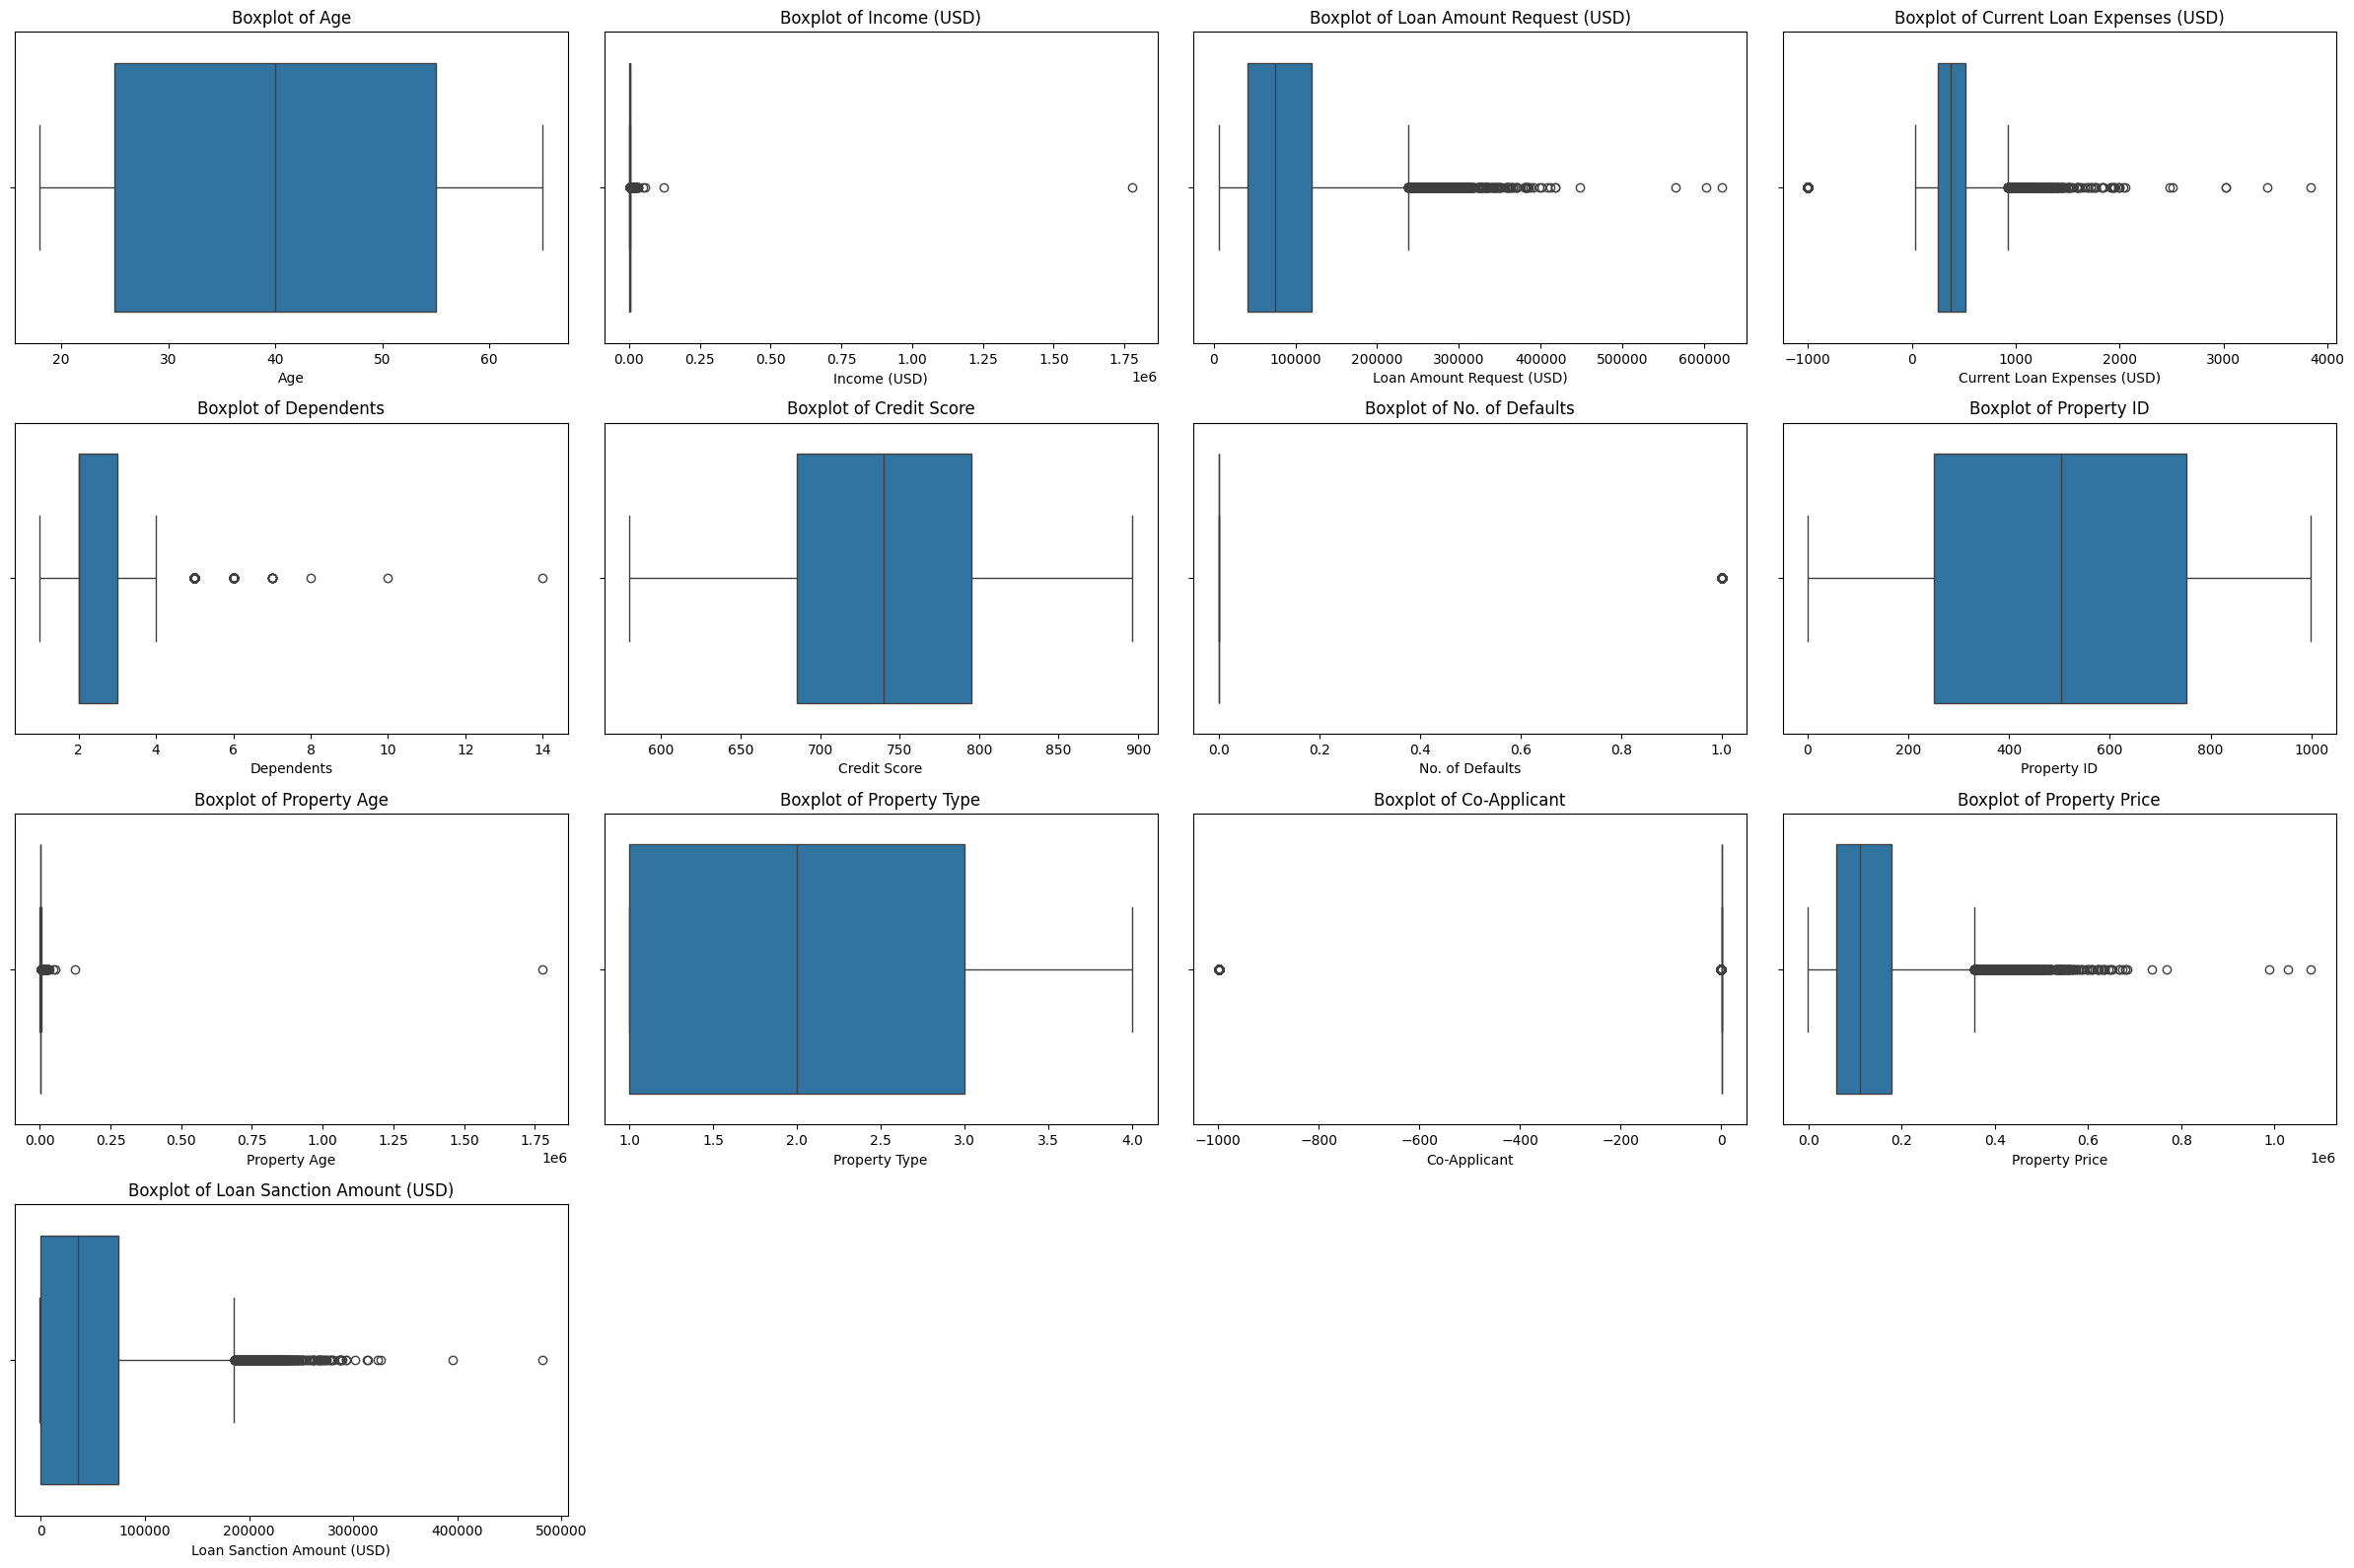

In [ ]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cols = 4
rows = 4

plt.figure(figsize=(6 * cols, 4 * rows))

for i, col in enumerate(num_cols):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


In [ ]:
def cap_outliers(df, col, lower_percentile=0.05, upper_percentile=0.95):
    lower = df[col].quantile(lower_percentile)
    upper = df[col].quantile(upper_percentile)
    df.loc[df[col] < lower, col] = lower
    df.loc[df[col] > upper, col] = upper
    return df


# Apply to all numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    df = cap_outliers(df, col)
print("Capping of outliers done")

Capping of outliers done


c. Encoding Categorical variables

In [ ]:
from sklearn.preprocessing import LabelEncoder

cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols = [col for col in cat_cols if col not in ['Customer ID', 'Name']]

le = LabelEncoder()

# Apply label encoding to each categorical column
for col in cat_cols:
    df.loc[:, col] = le.fit_transform(df[col].astype(str))

In [ ]:
print("After encoding all categorical variables")
df

After encoding all categorical variables


,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,0,56,1933.050000,1,7,14,1,72809.58,...,809.440000,0,2,746,1933.05000,4,0,1,119933.46,54607.18
1,C-33999,America Calderone,1,32,4867.821000,1,7,17,1,46837.47,...,780.400000,0,3,608,4855.43250,2,0,1,54791.00,37469.98
2,C-3770,Rosetta Verne,0,64,1065.603000,0,3,17,1,45593.04,...,833.150000,0,3,546,1074.09800,2,2,0,72440.58,36474.43
3,C-26480,Zoe Chitty,0,64,2630.574417,0,3,17,0,80057.92,...,832.700000,1,3,890,2631.11944,2,1,1,121441.51,56040.54
4,C-23459,Afton Venema,0,31,2614.770000,1,7,6,1,113858.89,...,745.550000,1,0,715,2614.77000,4,1,1,208567.91,74008.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,C-43723,Angelyn Clevenger,1,38,4867.821000,1,1,10,2,76657.90,...,853.410500,0,3,566,4855.43250,4,2,1,111096.56,68992.11
29996,C-32511,Silas Slaugh,1,20,1606.880000,1,7,8,1,66595.14,...,729.410000,0,1,175,1606.88000,3,2,1,73453.94,46616.60
29997,C-5192,Carmelo Lone,0,49,2630.574417,1,7,14,2,81410.08,...,739.885381,0,0,949,2631.11944,1,0,1,102108.02,61057.56
29998,C-12172,Carolann Osby,1,38,2417.710000,1,7,16,1,142524.10,...,677.270000,1,3,375,2417.71000,4,2,1,168194.47,99766.87


d. Standardize the features

In [ ]:
from sklearn.preprocessing import StandardScaler
df = df.copy()
target_col = 'Loan Sanction Amount (USD)'
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(target_col)
df.loc[:, num_cols] = df[num_cols].astype(float)

# Initialize and apply StandardScaler
scaler = StandardScaler()
df.loc[:, num_cols] = scaler.fit_transform(df[num_cols])
print("Standardization done")

Standardization done


/tmp/ipython-input-1062092336.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.99781606 -0.5039809   1.49841504 ...  0.55979195 -0.12853166
  1.43584017]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, num_cols] = scaler.fit_transform(df[num_cols])
/tmp/ipython-input-1062092336.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.90691011 -1.40449301 -1.40449301 ... -0.24879145  0.90691011
 -1.40449301]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, num_cols] = scaler.fit_transform(df[num_cols])
/tmp/ipython-input-1062092336.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.49071022 -0.49071022 -0.49071022 ... -0.49071022  2.03786259
 -0.49071022]' has dt

Exploratory Data Analysis

a. Distribution plots

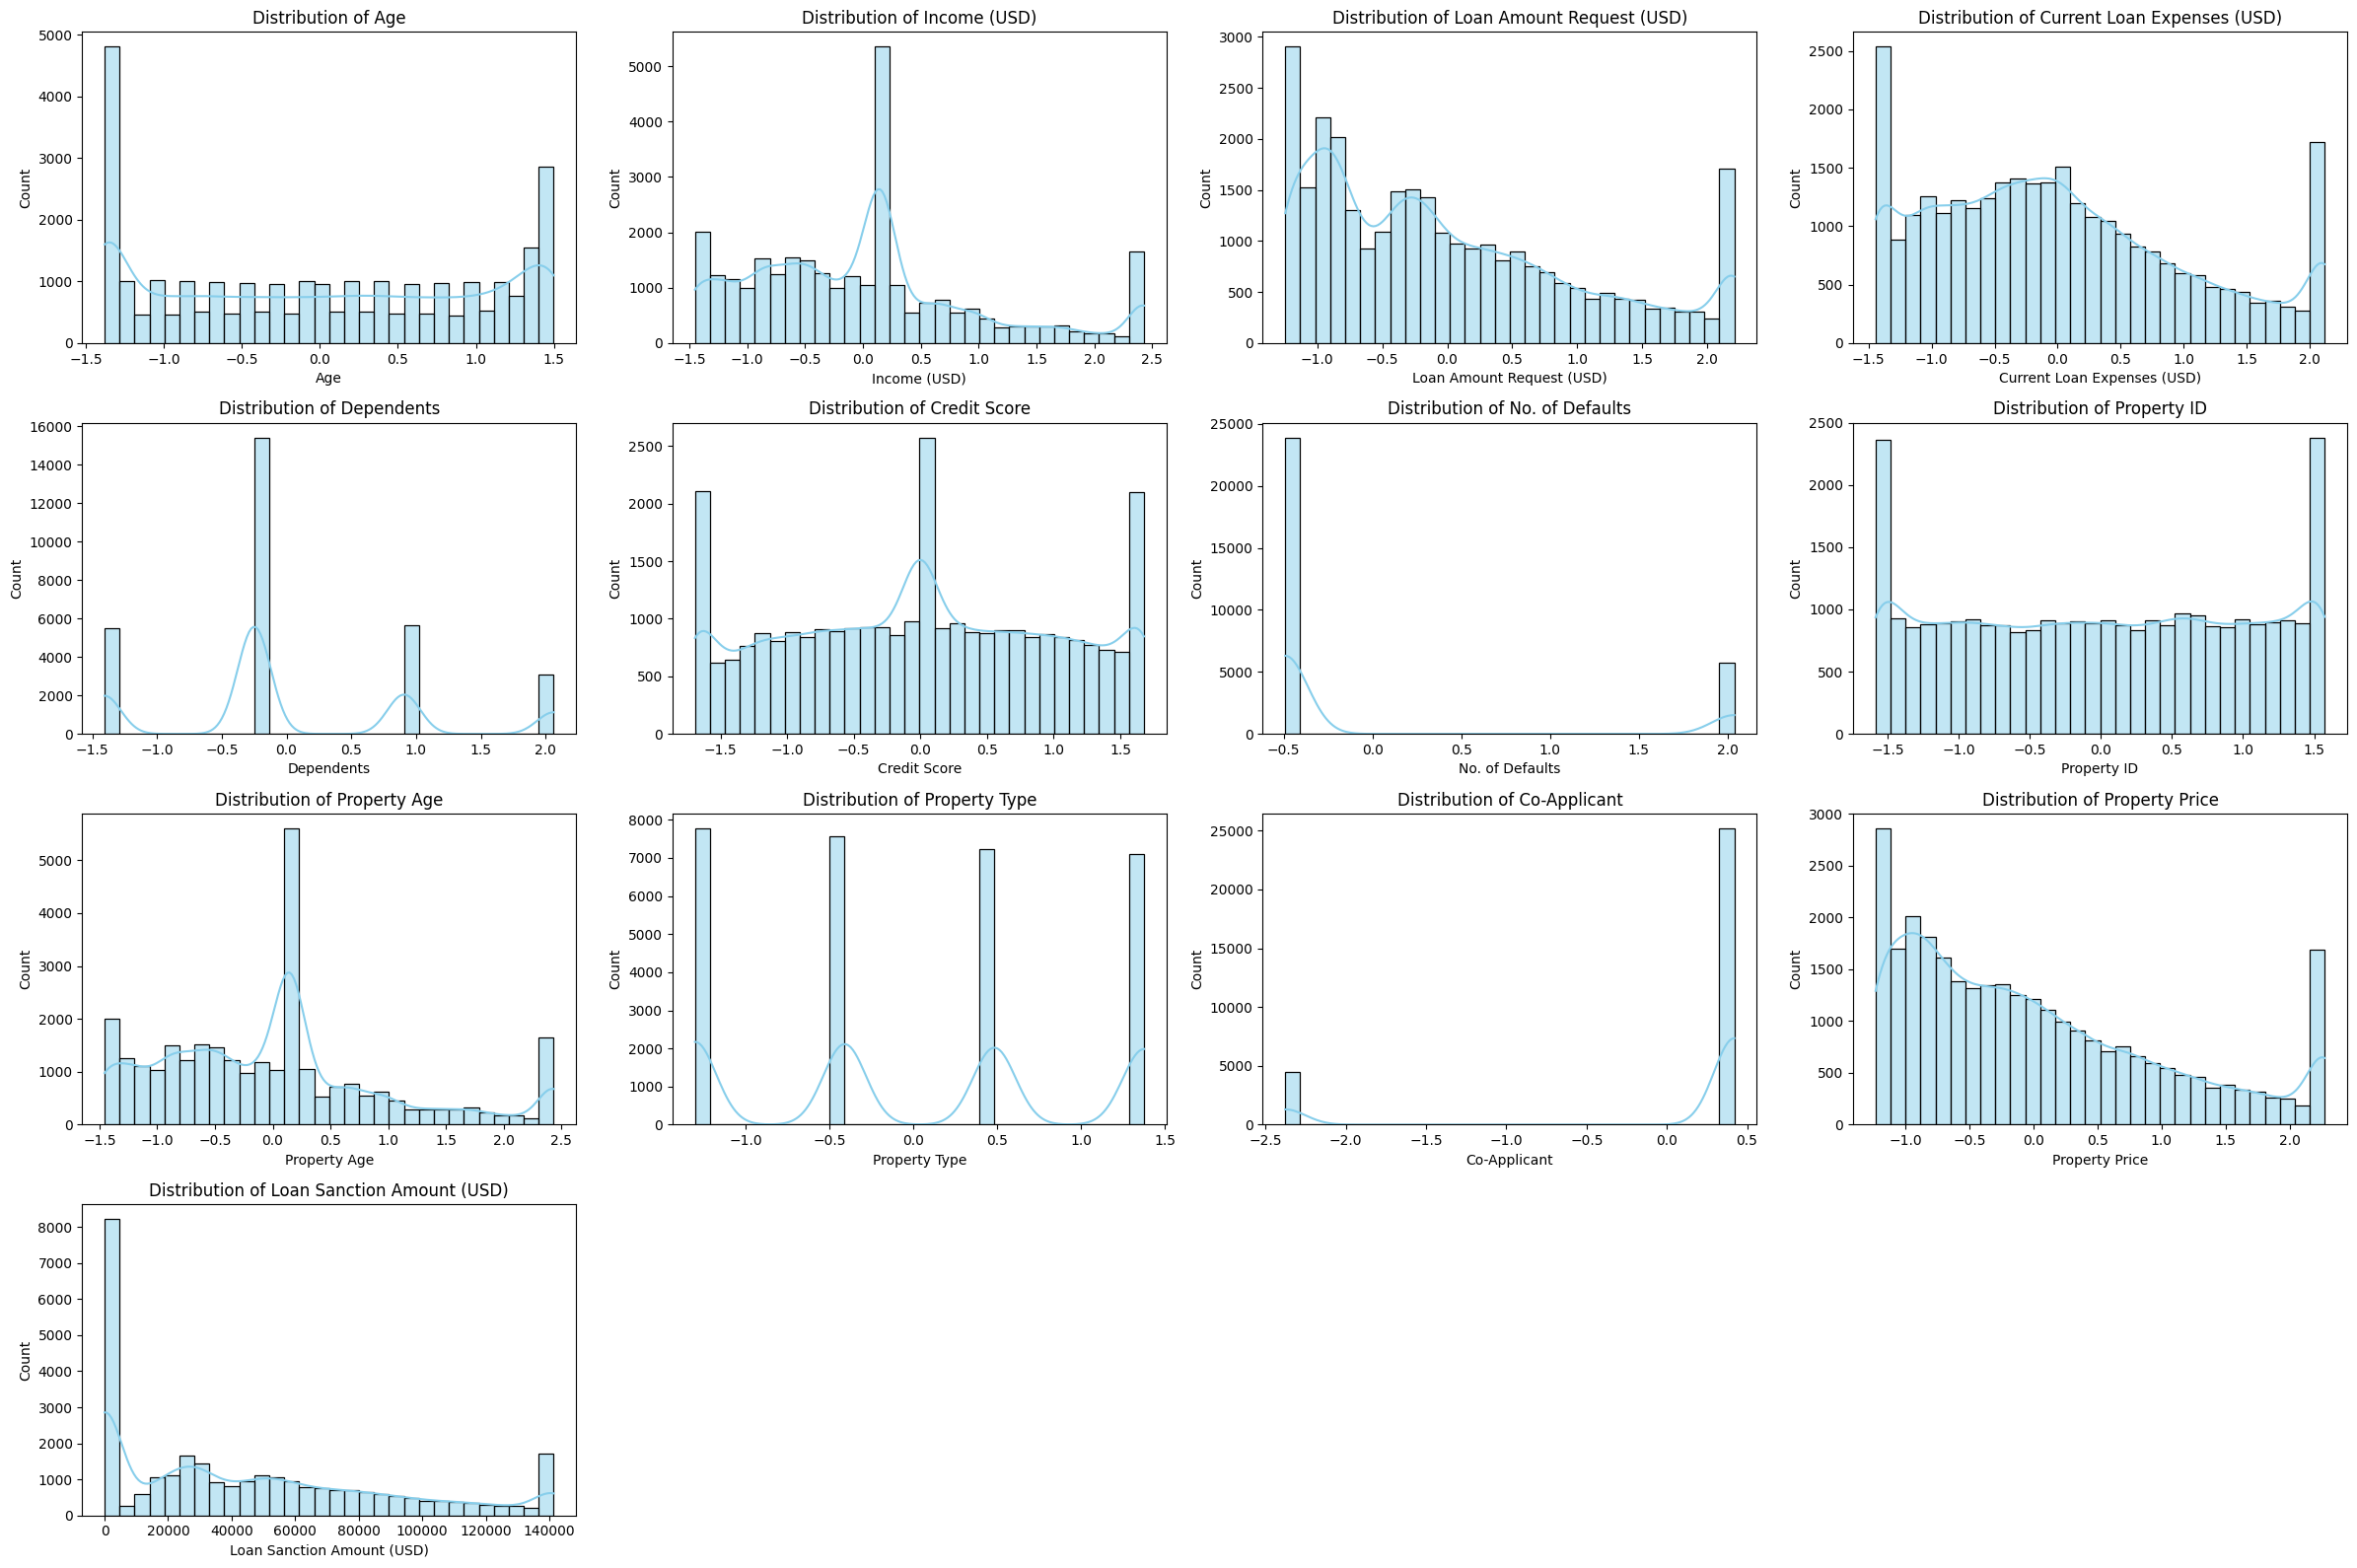

In [ ]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cols = 4
rows = 4

plt.figure(figsize=(6 * cols, 4 * rows))

for i, col in enumerate(num_cols):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

b. Scatter plots

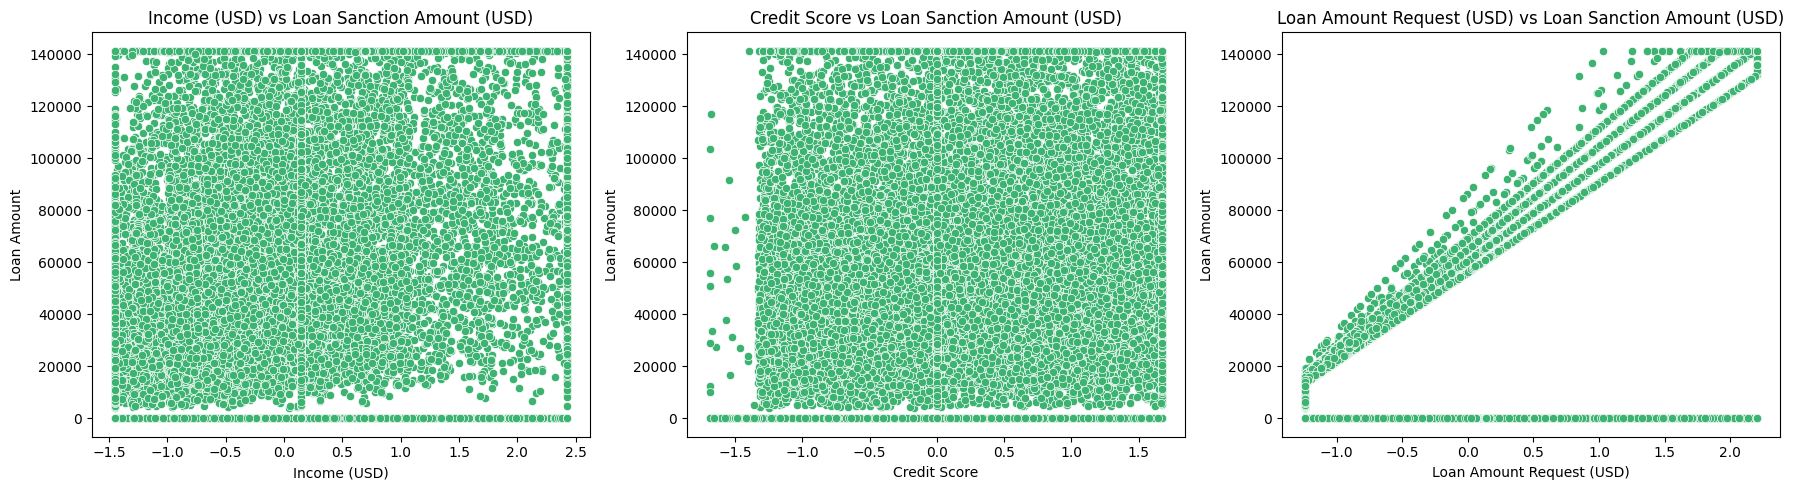

In [ ]:
key_features = ['Income (USD)', 'Credit Score', 'Loan Amount Request (USD)']
target_col = 'Loan Sanction Amount (USD)'

plt.figure(figsize=(6 * len(key_features), 5))

for i, col in enumerate(key_features):
    plt.subplot(1, len(key_features), i + 1)
    sns.scatterplot(x=df[col], y=df[target_col], color='mediumseagreen')
    plt.title(f'{col} vs {target_col}')
    plt.xlabel(col)
    plt.ylabel('Loan Amount')

plt.tight_layout()
plt.show()


### c. Correlation Heatmap


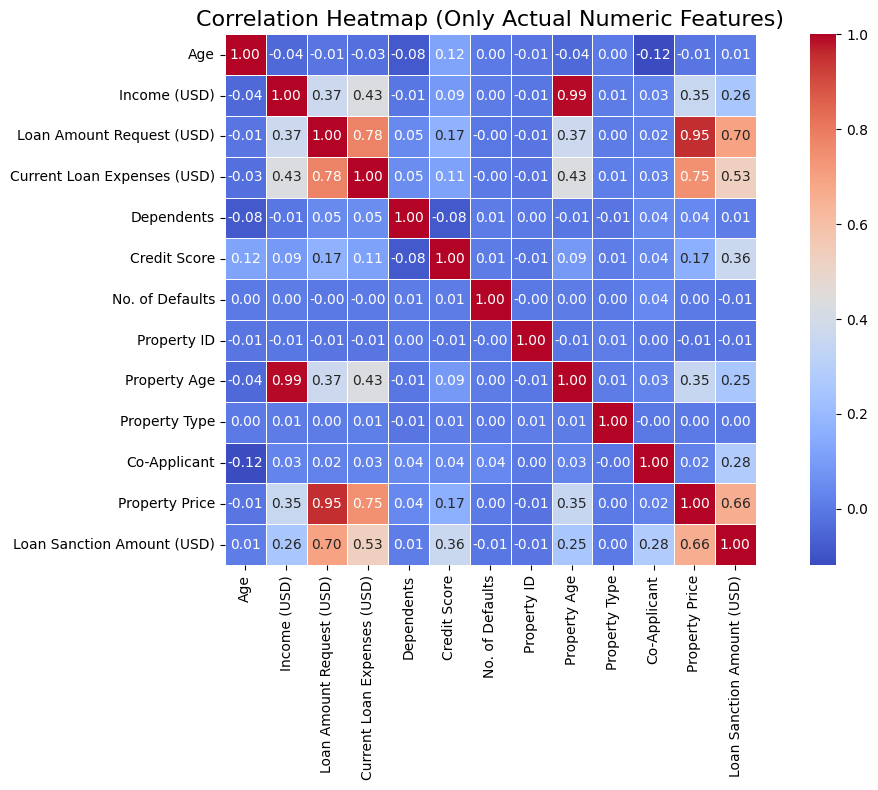

In [ ]:
original_cat_cols = ['Gender', 'Income Stability', 'Profession', 'Type of Employment',
                     'Location', 'Expense Type 1', 'Expense Type 2',
                     'Has Active Credit Card', 'Property Location']  # exclude 'Name', 'Customer ID'
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
reliable_num_cols = [col for col in num_cols if col not in original_cat_cols]

# Compute and plot correlation heatmap
corr_matrix = df[reliable_num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Heatmap (Only Actual Numeric Features)', fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
# Separate features and target
df = df.drop(['Customer ID', 'Name'], axis=1)
X = df.drop('Loan Sanction Amount (USD)', axis=1)
Y = df['Loan Sanction Amount (USD)']

3.Split into train and test sets.

In [ ]:
# TRAIN / VAL / TEST SPLIT
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Ensure y_train and y_test are 1-dimensional
y_train = y_train.to_numpy().ravel() if isinstance(y_train, pd.DataFrame) else y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel() if isinstance(y_test, pd.DataFrame) else y_test.to_numpy().ravel()

y_train = y_train.squeeze()
y_test = y_test.squeeze()

print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Train set: (20762, 21)
Validation set: (4449, 21)
Test set: (4449, 21)


In [ ]:
# Ensure y_train and y_test are 1-dimensional
y_train = y_train.values.ravel() if isinstance(y_train, pd.DataFrame) else y_train.ravel()
y_test = y_test.values.ravel() if isinstance(y_test, pd.DataFrame) else y_test.ravel()

4.Training the following Models:

Linear Regresssion

Ridge Regression

Lasso Regression

ElasticNet Regression

Polynomial Regression

Decision Tree Regression

Random Forest Regressor

Adaboost Regressor

Gradient Boost Regressor

Xg Boost Regressor

Support Vector Machine Regressor(Linear , Polynomial , rbf , Sigmoid )

In [ ]:
def evaluate_model(name, model, X_train, X_test, param_grid=None, param_dist=None):
    print(f"\n{name} - Hyperparameter Tuning Started")

    # GRIDSEARCHCV
    if param_grid:
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=5,
            scoring='r2',  # Change to 'accuracy' if classification
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        print(f"Best Params (GridSearchCV): {grid_search.best_params_}")
        print(f"Best CV Score (GridSearchCV): {grid_search.best_score_:.4f}")
    else:
        grid_search = None

    # RANDOMIZEDSEARCHCV
    if param_dist:
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=10,
            cv=5,
            scoring='r2',
            random_state=42,
            n_jobs=-1
        )
        random_search.fit(X_train, y_train)
        print(f"Best Params (RandomizedSearchCV): {random_search.best_params_}")
        print(f"Best CV Score (RandomizedSearchCV): {random_search.best_score_:.4f}")
    else:
        random_search = None

    # PICK BEST MODEL
    if grid_search and random_search:
        best_model = (
            grid_search if grid_search.best_score_ >= random_search.best_score_
            else random_search
        ).best_estimator_
    elif grid_search:
        best_model = grid_search.best_estimator_
    elif random_search:
        best_model = random_search.best_estimator_
    else:
        best_model = model

    # EVALUATE BEST MODEL
    start_time = time.time()
    best_model.fit(X_train, y_train)
    end_time = time.time()
    y_pred = best_model.predict(X_test)

    print(f"\n{name} Performance:")
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Adjusted R²: {adj_r2:.4f}")
    print(f"Training Time: {(end_time - start_time):.4f} seconds")

    # ACTUAL vs PREDICTED
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='red', linestyle='--', linewidth=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.grid(True)
    plt.show()

    # RESIDUAL PLOT
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 5))
    plt.scatter(y_pred, residuals, alpha=0.6, color='orange')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True)
    plt.show()

    # Bar Plot of Feature Coefficients (for linear models)

    if hasattr(best_model, 'coef_') and best_model.coef_.ndim == 1:
        feature_names = X_train.columns
        coefficients = best_model.coef_
        coef_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients
        }).sort_values(by='Coefficient', ascending=False)

        plt.figure(figsize=(6, 5))
        plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='green')
        plt.xlabel('Coefficient Value')
        plt.title('Feature Coefficients')
        plt.gca().invert_yaxis()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

Linear Regression


Linear Regression - Hyperparameter Tuning Started

Linear Regression Performance:
MAE: 19022.7680
MSE: 743473629.7468
RMSE: 27266.7129
R²: 0.5993
Adjusted R²: 0.5974
Training Time: 0.0317 seconds


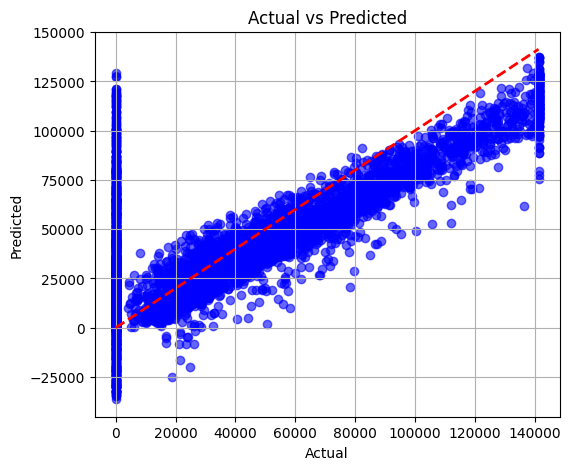

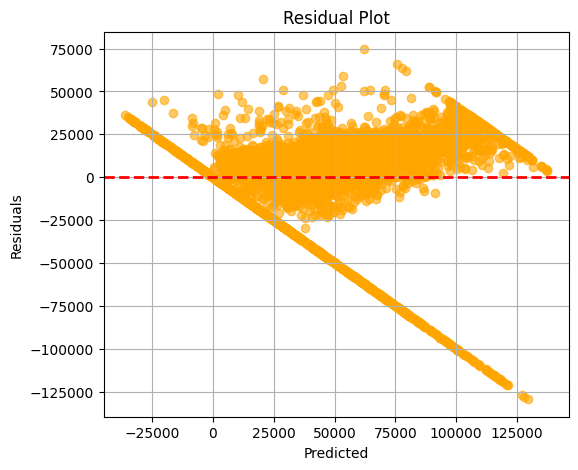

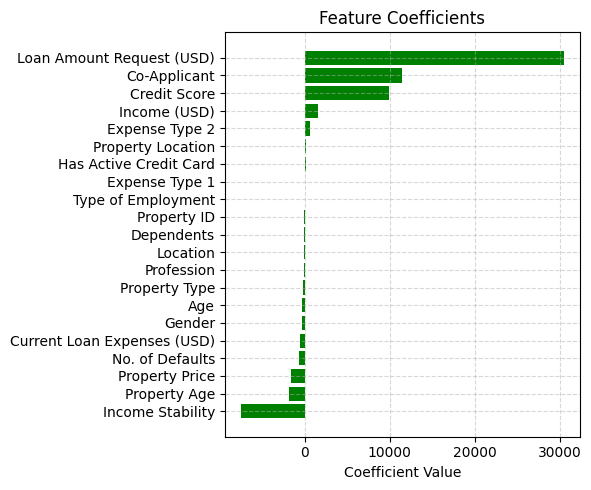

In [ ]:
lr_model = LinearRegression()
evaluate_model("Linear Regression", lr_model, X_train, X_test)

# Ridge Regression


Ridge Regression - Hyperparameter Tuning Started
Best Params (GridSearchCV): {'alpha': 10.0}
Best CV Score (GridSearchCV): 0.6165

Ridge Regression Performance:
MAE: 19023.6688
MSE: 743385227.5230
RMSE: 27265.0917
R²: 0.5994
Adjusted R²: 0.5975
Training Time: 0.1028 seconds


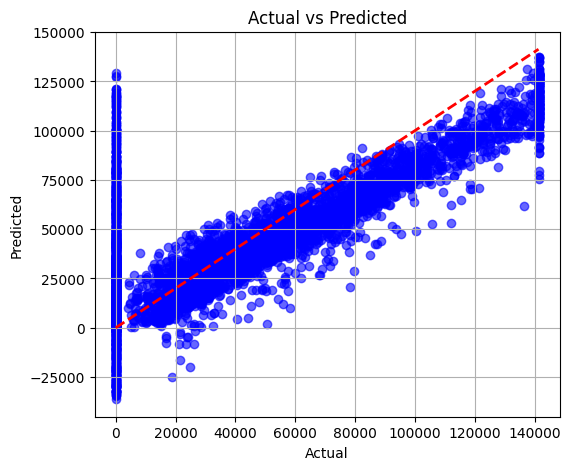

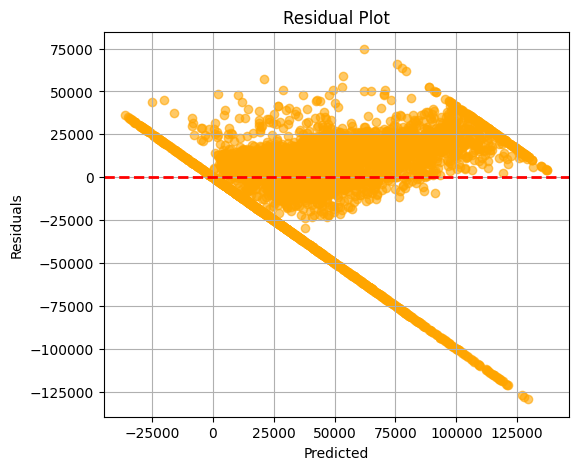

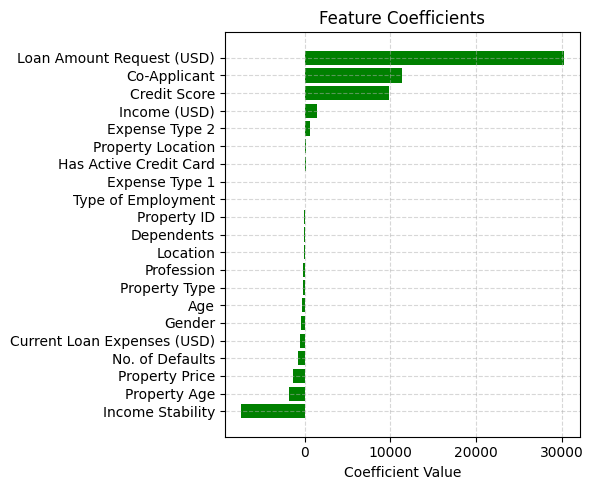

In [ ]:
ridge_model = Ridge()
param_grid_ridge = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
evaluate_model("Ridge Regression", ridge_model, X_train, X_test, param_grid=param_grid_ridge)

# Lasso Regression


Lasso Regression - Hyperparameter Tuning Started
Best Params (GridSearchCV): {'alpha': 10.0}
Best CV Score (GridSearchCV): 0.6165

Lasso Regression Performance:
MAE: 19021.9724
MSE: 743385537.3648
RMSE: 27265.0974
R²: 0.5994
Adjusted R²: 0.5975
Training Time: 1.2083 seconds


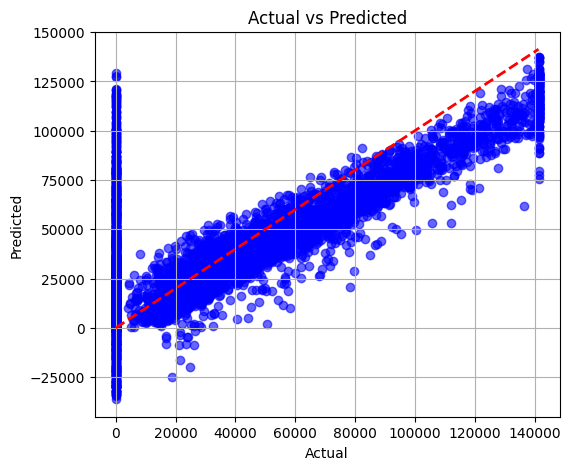

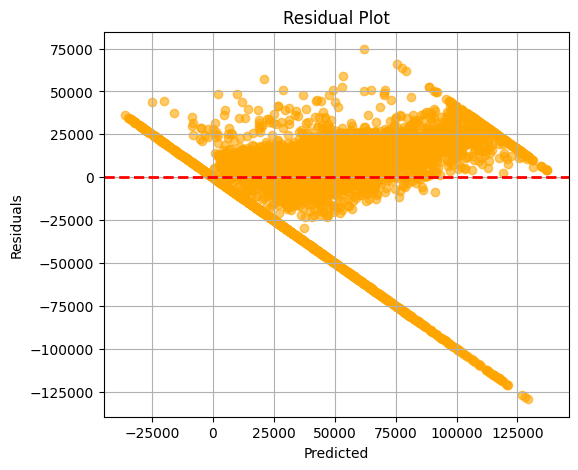

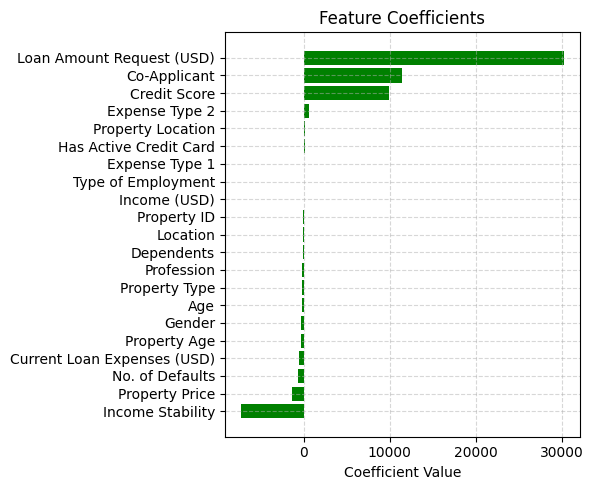

In [ ]:
lasso_model = Lasso()
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
evaluate_model("Lasso Regression", lasso_model, X_train, X_test, param_grid=param_grid_lasso)

# ElasticNet Regression


ElasticNet Regression - Hyperparameter Tuning Started
Best Params (GridSearchCV): {'alpha': 0.01, 'l1_ratio': 0.9}
Best CV Score (GridSearchCV): 0.6165

ElasticNet Regression Performance:
MAE: 19024.7809
MSE: 743299083.0087
RMSE: 27263.5119
R²: 0.5994
Adjusted R²: 0.5975
Training Time: 0.4766 seconds


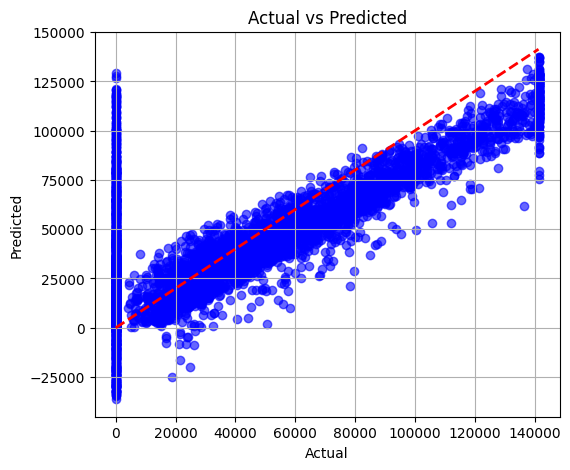

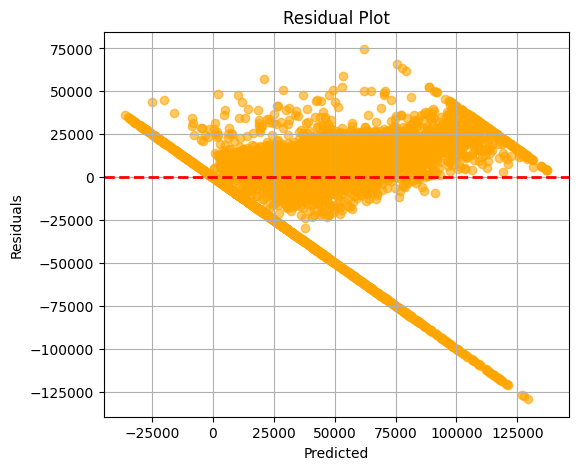

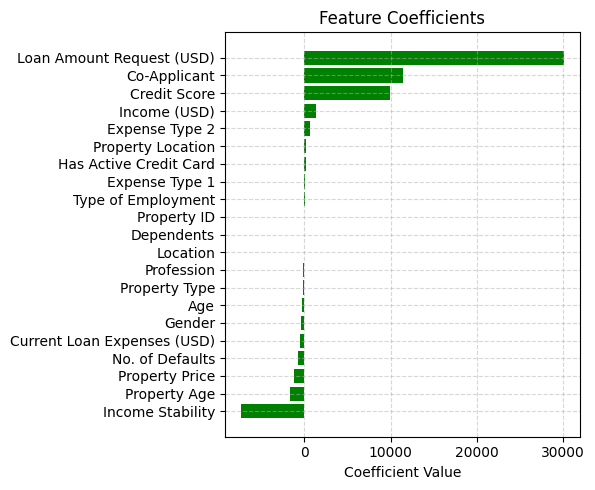

In [ ]:
elastic_net_model = ElasticNet()
param_grid_elastic = {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.9]}
evaluate_model("ElasticNet Regression", elastic_net_model, X_train, X_test, param_grid=param_grid_elastic)

# Polynomial Regression

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
poly_model = LinearRegression()
print("\nPolynomial Regression (Degree 2) - Evaluation")
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)

mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)
adj_r2_poly = 1 - (1 - r2_poly) * (len(y_test) - 1) / (len(y_test) - X_test_poly.shape[1] - 1)

print("Polynomial Regression Performance:")
print(f"MAE: {mae_poly:.4f}")
print(f"MSE: {mse_poly:.4f}")
print(f"RMSE: {rmse_poly:.4f}")
print(f"R²: {r2_poly:.4f}")
print(f"Adjusted R²: {adj_r2_poly:.4f}")


Polynomial Regression (Degree 2) - Evaluation
Polynomial Regression Performance:
MAE: 15352.0200
MSE: 626442733.7469
RMSE: 25028.8380
R²: 0.6624
Adjusted R²: 0.6421


# Decision Tree Regressor


Decision Tree Regressor - Hyperparameter Tuning Started
Best Params (GridSearchCV): {'max_depth': 7, 'min_samples_split': 5}
Best CV Score (GridSearchCV): 0.7463

Decision Tree Regressor Performance:
MAE: 11253.3360
MSE: 522070719.0379
RMSE: 22848.8669
R²: 0.7186
Adjusted R²: 0.7173
Training Time: 0.1371 seconds


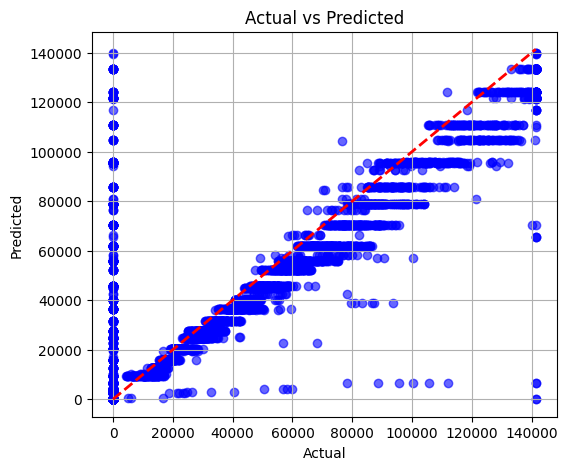

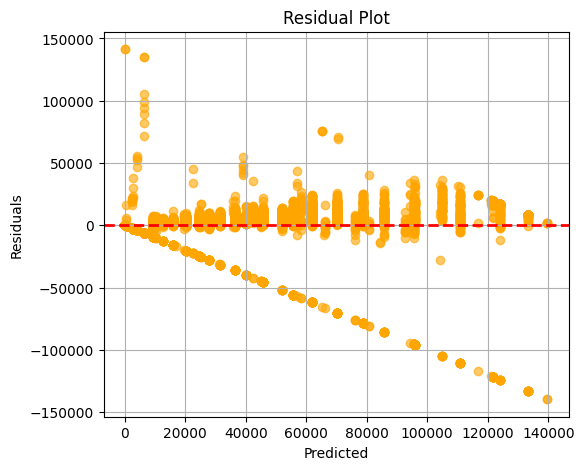

In [ ]:
dt_model = DecisionTreeRegressor(random_state=42)
param_grid_dt = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}
evaluate_model("Decision Tree Regressor", dt_model, X_train, X_test, param_grid=param_grid_dt)

# Random Forest Regressor


Random Forest Regressor - Hyperparameter Tuning Started
Best Params (GridSearchCV): {'max_depth': 10, 'n_estimators': 200}
Best CV Score (GridSearchCV): 0.7564

Random Forest Regressor Performance:
MAE: 10977.3239
MSE: 499397114.2878
RMSE: 22347.1948
R²: 0.7309
Adjusted R²: 0.7296
Training Time: 21.8331 seconds


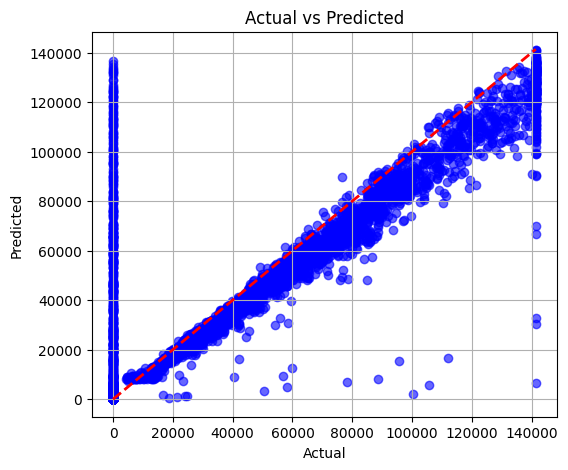

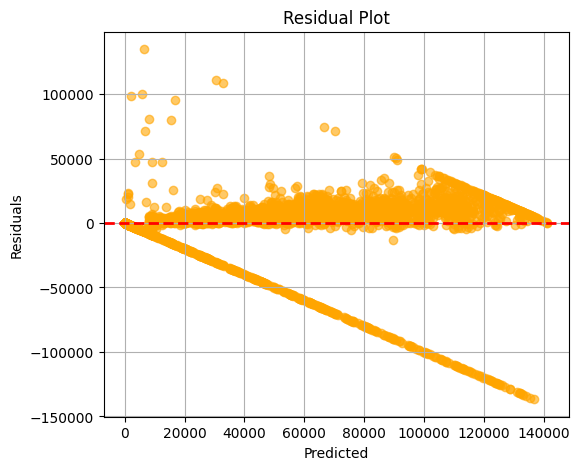

In [ ]:
# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}
evaluate_model("Random Forest Regressor", rf_model, X_train, X_test, param_grid=param_grid_rf)

# AdaBoost Regressor


AdaBoost Regressor - Hyperparameter Tuning Started
Best Params (GridSearchCV): {'learning_rate': 0.01, 'n_estimators': 100}
Best CV Score (GridSearchCV): 0.6295

AdaBoost Regressor Performance:
MAE: 17632.2481
MSE: 712708526.1417
RMSE: 26696.6014
R²: 0.6159
Adjusted R²: 0.6141
Training Time: 9.9643 seconds


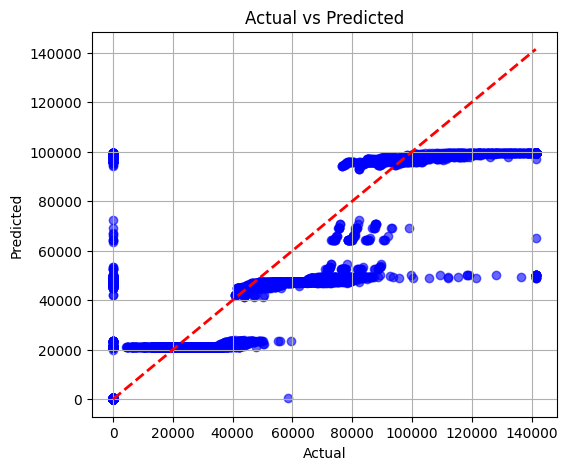

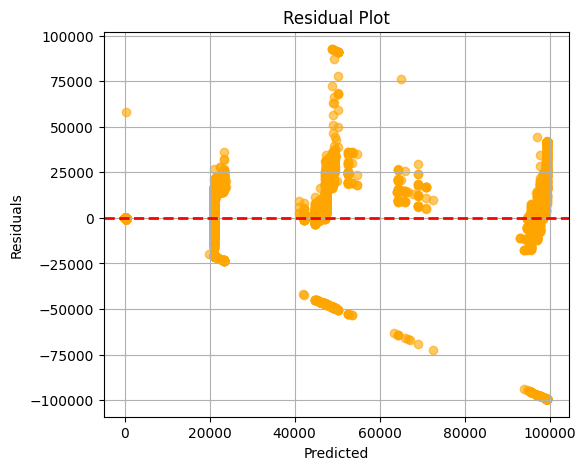

In [ ]:
adaboost_model = AdaBoostRegressor(random_state=42)
param_grid_ada = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1.0]}
evaluate_model("AdaBoost Regressor", adaboost_model, X_train, X_test, param_grid=param_grid_ada)

# Gradient Boosting Regressor


Gradient Boosting Regressor - Hyperparameter Tuning Started
Best Params (GridSearchCV): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best CV Score (GridSearchCV): 0.7583

Gradient Boosting Regressor Performance:
MAE: 11771.6979
MSE: 497687995.4729
RMSE: 22308.9219
R²: 0.7318
Adjusted R²: 0.7305
Training Time: 5.2001 seconds


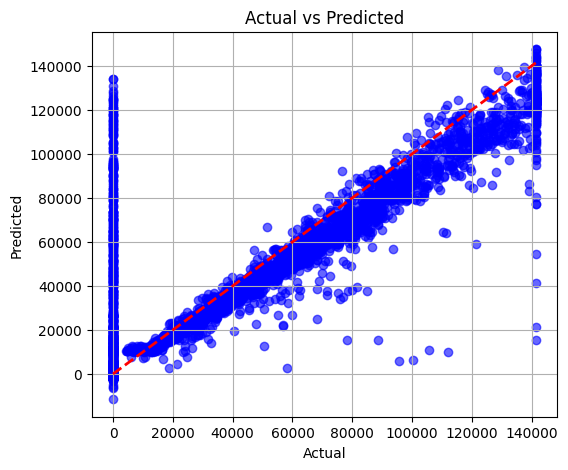

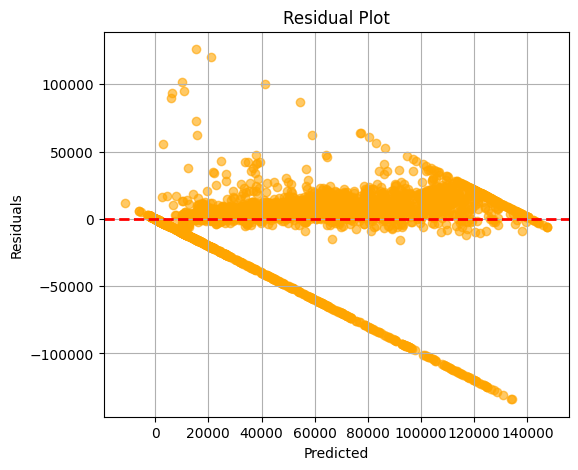

In [ ]:
gbr_model = GradientBoostingRegressor(random_state=42)
param_grid_gbr = {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.5], 'max_depth': [3, 5]}
evaluate_model("Gradient Boosting Regressor", gbr_model, X_train, X_test, param_grid=param_grid_gbr)

#XGBoost Regressor



XGBoost Regressor - Hyperparameter Tuning Started
Best Params (GridSearchCV): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best CV Score (GridSearchCV): 0.7567

XGBoost Regressor Performance:
MAE: 11513.9793
MSE: 503476815.0280
RMSE: 22438.2890
R²: 0.7287
Adjusted R²: 0.7274
Training Time: 0.2459 seconds


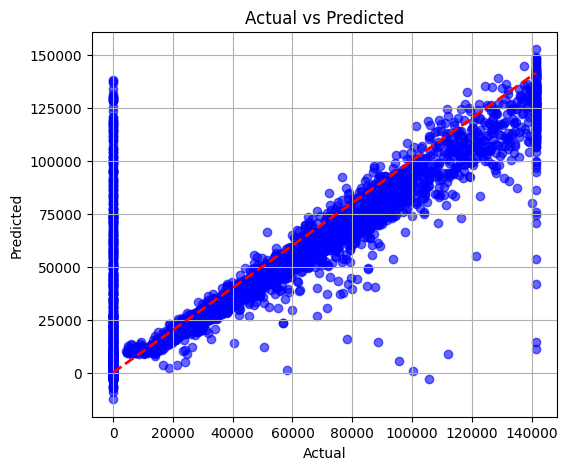

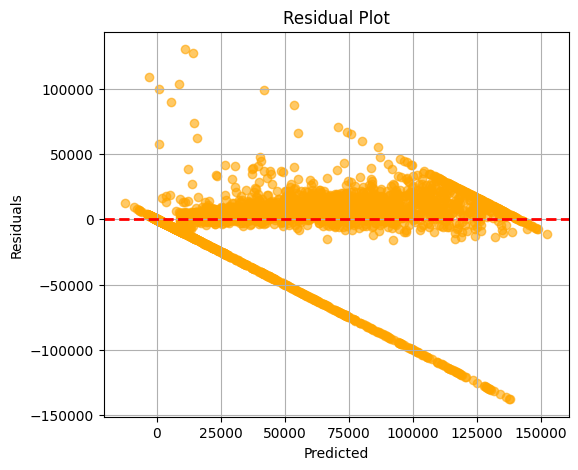

In [ ]:
xgb_model = XGBRegressor(random_state=42)
param_grid_xgb = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
evaluate_model("XGBoost Regressor", xgb_model, X_train, X_test, param_grid=param_grid_xgb)

# Support Vector Machine Regressor (SVR)

SVR - Linear Kernel


SVR (Linear Kernel) - Hyperparameter Tuning Started

SVR (Linear Kernel) Performance:
MAE: 21606.7676
MSE: 904134640.4310
RMSE: 30068.8317
R²: 0.5127
Adjusted R²: 0.5104
Training Time: 10.2368 seconds


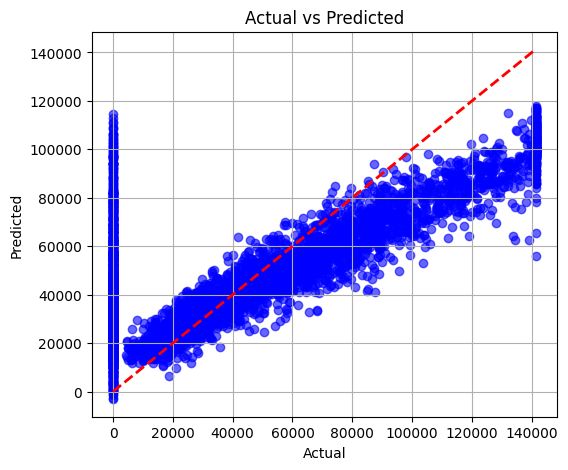

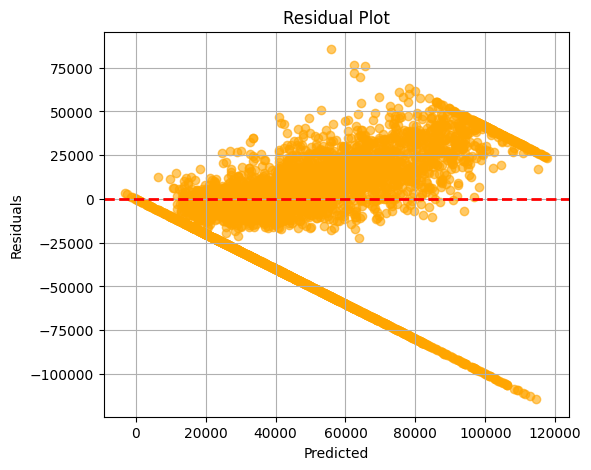

In [ ]:
svr_linear = SVR(kernel='linear', C=1.0)
evaluate_model("SVR (Linear Kernel)", svr_linear, X_train, X_test)

SVR - Polynomial Kernel


SVR (Polynomial Kernel) - Hyperparameter Tuning Started

SVR (Polynomial Kernel) Performance:
MAE: 34911.1932
MSE: 1937525737.2137
RMSE: 44017.3345
R²: -0.0442
Adjusted R²: -0.0491
Training Time: 11.8968 seconds


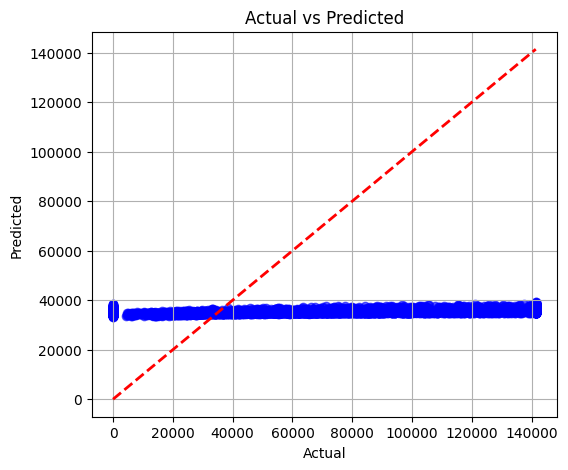

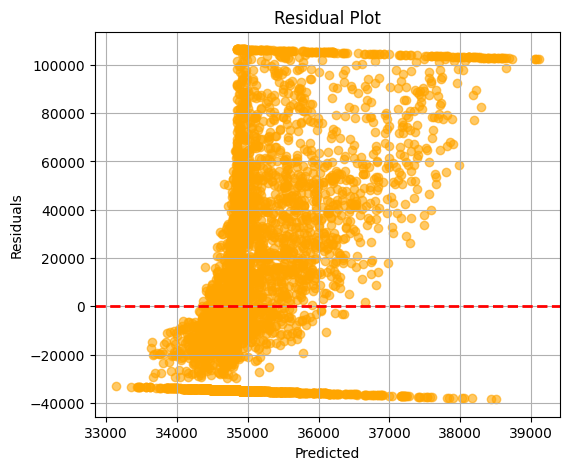

In [ ]:
svr_poly = SVR(kernel='poly', C=1.0, degree=3, gamma='scale')
evaluate_model("SVR (Polynomial Kernel)", svr_poly, X_train, X_test)

SVR - rbf Kernel


SVR (RBF Kernel) - Hyperparameter Tuning Started

SVR (RBF Kernel) Performance:
MAE: 35107.4829
MSE: 1960755499.5061
RMSE: 44280.4189
R²: -0.0567
Adjusted R²: -0.0617
Training Time: 22.7674 seconds


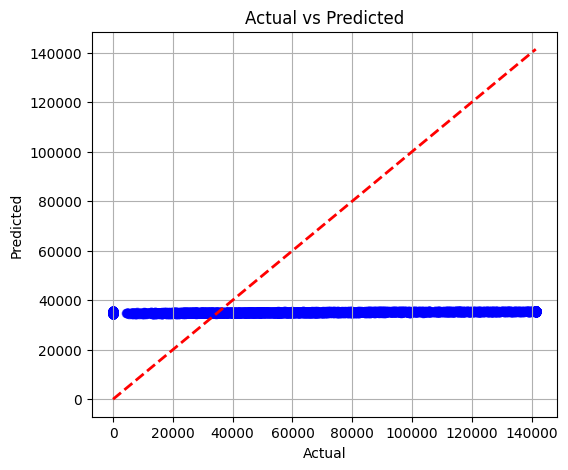

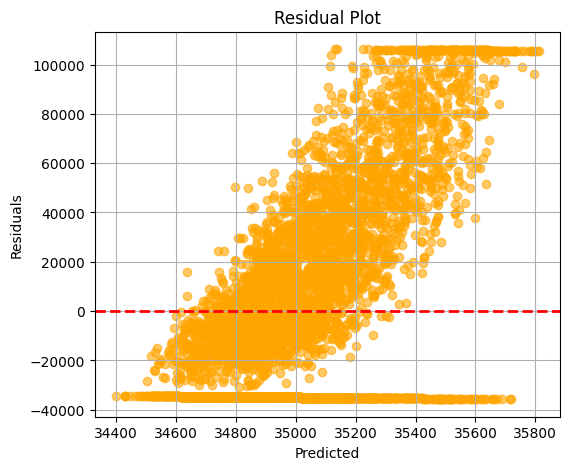

In [ ]:
svr_rbf = SVR(kernel='rbf', C=1.0, gamma='scale')
evaluate_model("SVR (RBF Kernel)", svr_rbf, X_train, X_test)

SVR - Sigma Kernel


SVR (Sigmoid Kernel) - Hyperparameter Tuning Started

SVR (Sigmoid Kernel) Performance:
MAE: 35174.2304
MSE: 1969145397.0455
RMSE: 44375.0538
R²: -0.0612
Adjusted R²: -0.0663
Training Time: 25.9221 seconds


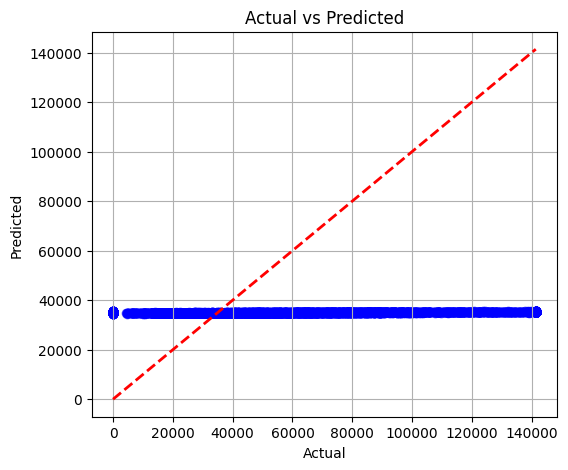

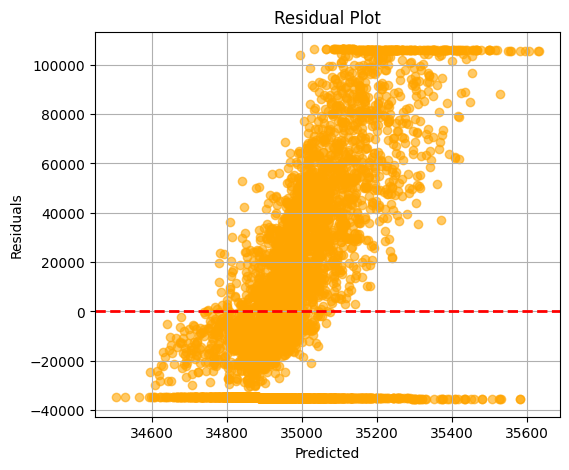

In [ ]:
svr_sigmoid = SVR(kernel='sigmoid', C=1.0, gamma='scale')
evaluate_model("SVR (Sigmoid Kernel)", svr_sigmoid, X_train, X_test)